<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/MLP/Spatial-Shift-MLP/Version-1/S2_MLP_V1-65_bands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select the best

def str_to_bool(x):
    return True if x == "True" else False

use_pearson_corr = "False"  #@param ["True", "False"]
patch_method = "extract"    #@param ["extract", "conv"]

H, W, B = 512, 512, 65               # height,width and band of image
P_S = 9                             #@param [3, 9, 15, 21]                         
patch_size = 3                      # Size of the patches to be extract from the input images
# valid patch size is that number which is divisible by 3 i.e. 3,6,9,12

train_percent = 75          #@param [75, 80, 90]
epoch = 300                #@param [100, 200, 300, 400]

LR_START = 3e-3
LR_MAX = 6e-3 
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout = 0.2
num_patches = (P_S//patch_size)**2

num_layers = "4"              #@param [1,2,3,4,5,6,7]
expansion_factor = 4              #@param [1,2,3,4,5,6,7]
projection_dim = "256"        #@param [64, 128, 256, 512, 1024]
tokens_mlp_dim = "128"         #@param [32, 64, 128, 256, 512, 1024]
dropout_ratio = 0.0         #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]

use_pearson_corr = str_to_bool(use_pearson_corr)
P_S = int(P_S)
train_percent = int(train_percent)
epoch = int(epoch)
tokens_mlp_dim = int(tokens_mlp_dim) 
channels_mlp_dim = tokens_mlp_dim
projection_dim = int(projection_dim)
dropout_ratio = float(dropout_ratio)
num_layers = int(num_layers)
expansion_factor = int(expansion_factor)

print("Number of patches per P_S: ", num_patches)
print("Size of each patch for MLP Mixture: ", patch_size)

Number of patches per P_S:  9
Size of each patch for MLP Mixture:  3


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc
import pickle

import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input,Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate,LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling1D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, Layer, MaxPool2D, UpSampling2D, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral
from imgaug import augmenters as iaa
import imgaug as ia
tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

AUTO = tf.data.AUTOTUNE
np.random.seed(1337)          # to get reproducible results
if use_pearson_corr:
    folder_path = "/content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/With Pearson correlation/"
else:
    folder_path = "/content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/"

try:
    os.mkdir(folder_path)
except:
    pass

In [ ]:
mat_x = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS.mat')['DIAS']
mat_y = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS_ref.mat')['DIAS_ref']

x, y = mat_x.reshape(H,W,B), mat_y.reshape(H,W)
x = x.astype('float16')

# Normalizing the data between 0,1
for i in range(B):
    band_min = x[:,:,i].min()
    band_max = x[:,:,i].max()
    band_range = band_max - band_min
    x[:,:,i] = (x[:,:,i] - band_min)/band_range

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')

X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1

print("shape of mat_x: ", mat_x.shape)
print("shape of mat_y: ", mat_y.shape)
print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape)
print()
print(f"{len(Y)*100/mat_y.shape[0]}% of data is labeled with {num_classes} classes")

shape of mat_x:  (512, 512, 65)
shape of mat_y:  (512, 512)

minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (512, 512, 65)
shape of y:  (512, 512)

shape of padded_x:  (520, 520, 65)

10525.9765625% of data is labeled with 8 classes


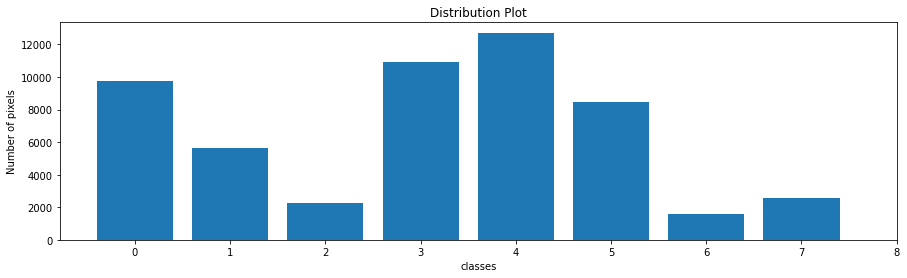

In [ ]:
class_labels, value_counts = np.unique(mat_y, return_counts = True)
plt.figure(figsize = (15,4))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train, x_test,y_train,y_test = tf.cast(np.array(x_train), tf.float32), tf.cast(np.array(x_test), tf.float32), np.array(y_train), np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (40419, 9, 9, 65) 
x_test: (13474, 9, 9, 65) 
y_train: (40419,) 
y_test: (13474,)


### Prediction and performance measure functions

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    if W/2 == W//2:
        y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    else:
        y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2+1, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        try:
            os.mkdir(folder_path + "Results/")
        except:
            pass
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)

    try:
        os.mkdir(folder_path + "Results/" )
    except:
        pass

    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure" + ".png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S)+ " Performance Measure" + ".png"
        fig.savefig(path)

### Building the classes and function for model

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S
    
    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))
    
        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)
    
        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

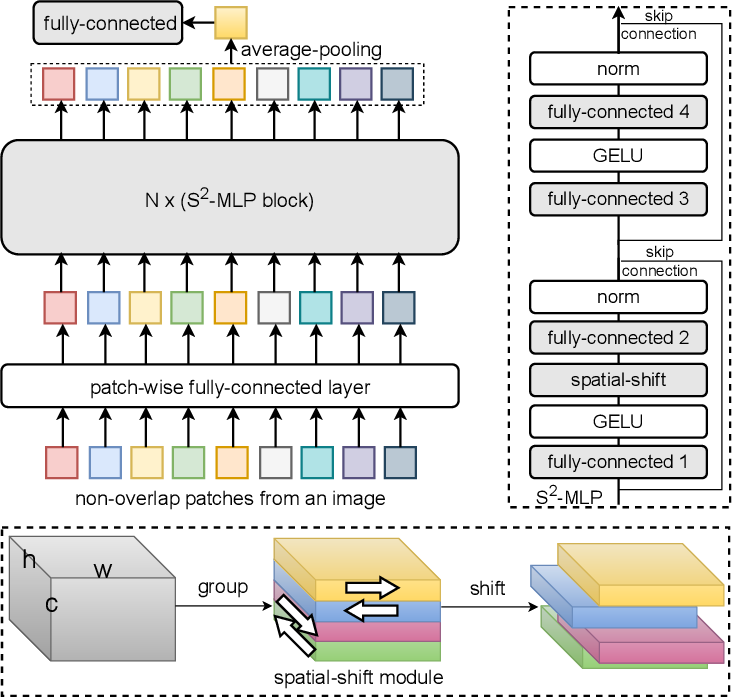

In [ ]:
# def Patch_image(images, hidden_dim=256,patch_size=3,patch_method='extract'):
#     if patch_method.lower() == 'conv':
#         x = Conv2D(hidden_dim, patch_size, patch_size)(images)                                         # shape(B, 3, 3, 256)
#         x = Reshape([-1, x.shape[-1]])(x)                             # shape(B, 9, 256)
#     else:
#         batch_size = tf.shape(images)[0]
#         # patches = image_to_patches(x)
#         patches = tf.image.extract_patches(images=images, sizes=[1, patch_size, patch_size, 1], 
#                                             strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding="VALID",)
#         patch_dims = patches.shape[-1]
#         x = Reshape([-1, patch_dims])(patches)               # shape = (B, 9, (3*3*372)) ---> (B, 9, 3348)
#     return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, hidden_dim = 256, patch_size = 3, patch_method='extract', **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.patch_method = patch_method.lower()

    def call(self, images):
        if self.patch_method == "conv":
            x = Conv2D(self.hidden_dim, patch_size, patch_size)(images)              # shape(B, 3, 3, 256)
            patches = Reshape([-1, x.shape[-1]])(x)                                   # shape(B, 9, 256)
            return patches
        else:
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1],
                                            rates=[1, 1, 1, 1], padding="VALID",)
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "hidden_dim": self.hidden_dim,
            "patch_method": self.patch_method
        })
        return config

In [ ]:
def mlp_block(x, hidden_dim, dropout_ratio = 0.1):
    y = Dense(hidden_dim)(x)
    y = tf.nn.gelu(y)
    y = Dropout(dropout_ratio)(y)
    return Dense(x.shape[-1])(y)

In [ ]:
class Linear(layers.Layer):
    def __init__(self, units = 32, bias = True, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
        self.bias = bias
    
    def build(self, input_shape):
        # initialize the weights
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),trainable=True)
        if self.bias:
            b_init = tf.zeros_initializer()
            self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "units": self.units,
            "bias" : self.bias
        })
        return config

In [ ]:
class Spatial_Shift(layers.Layer):
    def __init__(self, **kwargs):
        super(Spatial_Shift, self).__init__(**kwargs)
    
    def forward(self, x, **kwargs):
        b,w,h,c = x.shape
        x[:,1:,:,:c//4] = x[:,:w-1,:,:c//4]
        x[:,:w-1,:,c//4:c//2] = x[:,1:,:,c//4:c//2]
        x[:,:,1:,c//2:c*3//4] = x[:,:,:h-1,c//2:c*3//4]
        x[:,:,:h-1,3*c//4:] = x[:,:,1:,3*c//4:]
        return x

In [ ]:
class Shifted_MLP(layers.Layer):
    def __init__(self, d_model, expansion_factor = 4, dropout = 0.0, **kwargs):
        super(Shifted_MLP, self).__init__(**kwargs)
        self.d_model = d_model
        self.expansion_factor = expansion_factor
        self.dropout = dropout

        self.norm1 = LayerNormalization(axis = -1, epsilon=1e-6)
        self.norm2 = LayerNormalization(axis = -1, epsilon=1e-6)
        self.linear1 = Linear(d_model, bias = True)
        self.act = activations.gelu
        self.shift = Spatial_Shift()
        self.linear2 = Linear(d_model)
        self.linear3 = Linear(d_model * expansion_factor, bias = True)
        self.linear4 = Linear(d_model, bias = True)
        self.dropout = Dropout(rate = dropout)

    def block_1(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.shift(x)
        x = self.linear2(x)
        return x

    def block_2(self, x):
        x = self.linear3(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.dropout(x)
        return x

    def call(self, x, depth):
        for _ in range(depth):
            x = self.block_1(self.norm1(x)) + x
            x = self.block_2(self.norm2(x)) + x
        return x

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "expansion_factor" : self.expansion_factor,
            "dropout": self.dropout,
        })
        return config

In [ ]:
# class PreNormResidual(layers.Layer):
#     def __init__(self, dim, fn):
#         super().__init__()
#         self.fn = fn
#         self.norm = LayerNormalization(axis = -1)

#     def call(self, x):
#         return self.fn(self.norm(x)) + x

# class Shifted_MLP(layers.Layer):
#     def __init__(self, d_model, depth, expansion_factor = 4, dropout = 0., **kwargs):
#         super(Shifted_MLP, self).__init__(**kwargs)

#         self.model = Sequential(
#             *[Sequential(
#                 PreNormResidual(d_model, Sequential(
#                     Linear(d_model),
#                     activations.gelu(),
#                     Spatial_Shift(),
#                     Linear(d_model),
#                 )),
#                 PreNormResidual(d_model, Sequential(
#                     Linear(d_model * expansion_factor),
#                     activations.gelu(),
#                     Dropout(dropout),
#                     Linear(d_model),
#                     Dropout(dropout),
#                 ))
#             ) for _ in range(depth)]
#         )
    
#     def call(self, x):       
#         x = self.model(x)
#         return x

#     def get_config(self, **kwargs):
#         config = super().get_config()
#         config.update({
#             "d_model": self.d_model,
#             "depth": self.depth,
#             "expansion_factor" : self.expansion_factor,
#             "dropout": self.dropout,
#         })
#         return config

In [ ]:
def S2_MLP_model(input_shape = (P_S, P_S, B), patch_size = 3, num_classes = 7, use_pearson_corr = False, num_layers = 4,
                    projection_dim = 256, tokens_mlp_dim = 128, expansion_factor = 4, dropout_ratio = 0.0, patch_method='extract'):
    inputs = layers.Input(shape=input_shape)                                          # shape = (9,9,372)
    b = inputs.shape[0]
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)                                  # shape = (9,9,372)
    else:
        x0 = inputs
    
    patches = Patches(hidden_dim = projection_dim, patch_size = patch_size, patch_method=patch_method)(x0)
    # if tokens_mlp_dim != projection_dim:
    patches = Dense(tokens_mlp_dim)(patches)
        
    x = Shifted_MLP(d_model = tokens_mlp_dim, expansion_factor = expansion_factor, dropout = dropout_ratio)(patches, num_layers)
    # x = Shifted_MLP(d_model = tokens_mlp_dim, depth = num_layers, expansion_factor = expansion_factor, dropout = dropout_ratio)(patches)


    x = Linear(num_classes)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    model = Model(inputs = inputs, outputs = outputs, name = "S2-MLP")
    return model

In [ ]:
model = S2_MLP_model((P_S, P_S, B), patch_size , num_classes, use_pearson_corr, num_layers,
                        projection_dim, tokens_mlp_dim,expansion_factor, dropout_ratio, patch_method)

In [ ]:
model.summary()

Model: "S2-MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 65)]        0         
                                                                 
 patches (Patches)           (None, None, 585)         0         
                                                                 
 dense (Dense)               (None, None, 128)         75008     
                                                                 
 shifted_mlp (Shifted_MLP)   (None, None, 128)         165248    
                                                                 
 linear_4 (Linear)           (None, None, 8)           1032      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                            

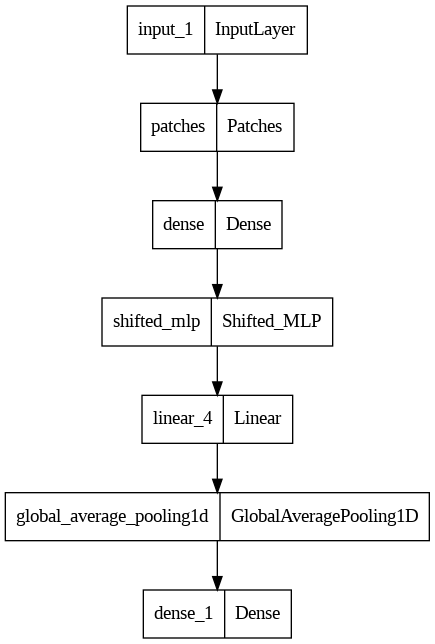

In [ ]:
plot_model(model)

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


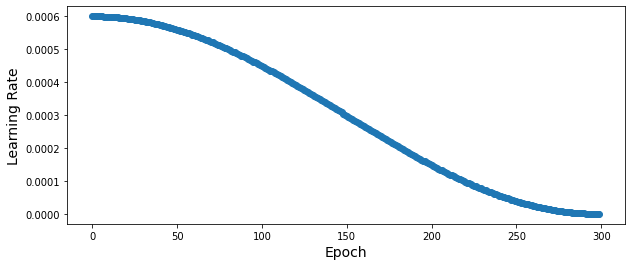

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4 
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
filepath = folder_path +"Trained models/"+ str(train_percent)+"% ps_"+str(P_S)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
callbacks_list = [checkpoint, lr_callback]
model.compile(optimizer=optimizers.Adam(0.000003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(train_dataset, validation_data = (test_dataset), validation_freq = 1, batch_size = 32, callbacks=callbacks_list, shuffle = False, epochs=epochs)
start_time = time.time()
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), validation_freq = 1, batch_size = BATCH_SIZE, callbacks=callbacks_list, shuffle = False, 
                    epochs=epoch, use_multiprocessing=True)
end_time = time.time()
tt = end_time - start_time
print("total training time: ", tt)


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/300
314/316 [============================>.] - ETA: 0s - loss: 0.7641 - accuracy: 0.7263
Epoch 1: val_accuracy improved from -inf to 0.82455, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 32s 39ms/step - loss: 0.7625 - accuracy: 0.7267 - val_loss: 0.4902 - val_accuracy: 0.8246 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005999834433585453.
Epoch 2/300
315/316 [============================>.] - ETA: 0s - loss: 0.5201 - accuracy: 0.8133
Epoch 2: val_accuracy improved from 0.82455 to 0.85862, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.5198 - accuracy: 0.8134 - val_loss: 0.4007 - val_accuracy: 0.8586 - lr: 5.9998e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005999337752619684.
Epoch 3/300
315/316 [============================>.] - ETA: 0s - loss: 0.4460 - accuracy: 0.8383
Epoch 3: val_accuracy improved from 0.85862 to 0.87762, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 28ms/step - loss: 0.4458 - accuracy: 0.8384 - val_loss: 0.3408 - val_accuracy: 0.8776 - lr: 5.9993e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005998510011934292.
Epoch 4/300
313/316 [============================>.] - ETA: 0s - loss: 0.3995 - accuracy: 0.8532
Epoch 4: val_accuracy improved from 0.87762 to 0.89157, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 10s 30ms/step - loss: 0.3993 - accuracy: 0.8533 - val_loss: 0.3137 - val_accuracy: 0.8916 - lr: 5.9985e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005997351302908542.
Epoch 5/300
316/316 [==============================] - ETA: 0s - loss: 0.3760 - accuracy: 0.8631
Epoch 5: val_accuracy improved from 0.89157 to 0.89424, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.3760 - accuracy: 0.8631 - val_loss: 0.3007 - val_accuracy: 0.8942 - lr: 5.9974e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0005995861753459288.
Epoch 6/300
314/316 [============================>.] - ETA: 0s - loss: 0.3451 - accuracy: 0.8734
Epoch 6: val_accuracy did not improve from 0.89424
316/316 [==============================] - 6s 19ms/step - loss: 0.3448 - accuracy: 0.8734 - val_loss: 0.2872 - val_accuracy: 0.8942 - lr: 5.9959e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0005994041528026842.
Epoch 7/300
314/316 [============================>.] - ETA: 0s - loss: 0.3309 - accuracy: 0.8796
Epoch 7: val_accuracy did not improve from 0.89424
316/316 [==============================] - 6s 18ms/step - loss: 0.3306 - accuracy: 0.8796 - val_loss: 0.3104 - val_accuracy: 0.8829 - lr: 5.9940e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0005991890827556831.
Epoch 8/300
314/3

316/316 [==============================] - 9s 28ms/step - loss: 0.3303 - accuracy: 0.8788 - val_loss: 0.2771 - val_accuracy: 0.9016 - lr: 5.9919e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0005989409889478.
Epoch 9/300
314/316 [============================>.] - ETA: 0s - loss: 0.2791 - accuracy: 0.8954
Epoch 9: val_accuracy improved from 0.90159 to 0.93454, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 28ms/step - loss: 0.2787 - accuracy: 0.8955 - val_loss: 0.1832 - val_accuracy: 0.9345 - lr: 5.9894e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0005986598987676014.
Epoch 10/300
316/316 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9039
Epoch 10: val_accuracy did not improve from 0.93454
316/316 [==============================] - 6s 19ms/step - loss: 0.2597 - accuracy: 0.9039 - val_loss: 0.2183 - val_accuracy: 0.9141 - lr: 5.9866e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0005983458432463212.
Epoch 11/300
316/316 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9136
Epoch 11: val_accuracy did not improve from 0.93454
316/316 [==============================] - 6s 18ms/step - loss: 0.2354 - accuracy: 0.9136 - val_loss: 0.2289 - val_accuracy: 0.9128 - lr: 5.9835e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0005979988570544356.
Epoch 12/3

316/316 [==============================] - 9s 27ms/step - loss: 0.2205 - accuracy: 0.9199 - val_loss: 0.1597 - val_accuracy: 0.9383 - lr: 5.9762e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0005972062495135974.
Epoch 14/300
316/316 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9153
Epoch 14: val_accuracy did not improve from 0.93825
316/316 [==============================] - 6s 18ms/step - loss: 0.2331 - accuracy: 0.9153 - val_loss: 0.2593 - val_accuracy: 0.9142 - lr: 5.9721e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0005967607156653538.
Epoch 15/300
313/316 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9246
Epoch 15: val_accuracy improved from 0.93825 to 0.95480, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 30ms/step - loss: 0.2087 - accuracy: 0.9248 - val_loss: 0.1332 - val_accuracy: 0.9548 - lr: 5.9676e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0005962824261382637.
Epoch 16/300
314/316 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9242
Epoch 16: val_accuracy did not improve from 0.95480
316/316 [==============================] - 6s 18ms/step - loss: 0.2100 - accuracy: 0.9242 - val_loss: 0.1228 - val_accuracy: 0.9546 - lr: 5.9628e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0005957714337335819.
Epoch 17/300
315/316 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9238
Epoch 17: val_accuracy did not improve from 0.95480
316/316 [==============================] - 6s 19ms/step - loss: 0.2105 - accuracy: 0.9237 - val_loss: 0.1489 - val_accuracy: 0.9458 - lr: 5.9577e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0005952277948628305.
Epoch 18/3

316/316 [==============================] - 9s 28ms/step - loss: 0.1592 - accuracy: 0.9424 - val_loss: 0.1201 - val_accuracy: 0.9557 - lr: 5.9128e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0005905137153808655.
Epoch 25/300
314/316 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9309
Epoch 25: val_accuracy improved from 0.95569 to 0.96163, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.1928 - accuracy: 0.9311 - val_loss: 0.1002 - val_accuracy: 0.9616 - lr: 5.9051e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0005897113665898402.
Epoch 26/300
314/316 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9418
Epoch 26: val_accuracy did not improve from 0.96163
316/316 [==============================] - 6s 20ms/step - loss: 0.1594 - accuracy: 0.9419 - val_loss: 0.1196 - val_accuracy: 0.9558 - lr: 5.8971e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0005888770403399724.
Epoch 27/300
313/316 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9430
Epoch 27: val_accuracy improved from 0.96163 to 0.96415, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 29ms/step - loss: 0.1569 - accuracy: 0.9433 - val_loss: 0.0981 - val_accuracy: 0.9642 - lr: 5.8888e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0005880108287375503.
Epoch 28/300
315/316 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9472
Epoch 28: val_accuracy did not improve from 0.96415
316/316 [==============================] - 6s 18ms/step - loss: 0.1428 - accuracy: 0.9473 - val_loss: 0.1124 - val_accuracy: 0.9581 - lr: 5.8801e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.000587112827408878.
Epoch 29/300
316/316 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9488
Epoch 29: val_accuracy improved from 0.96415 to 0.96935, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 29ms/step - loss: 0.1414 - accuracy: 0.9488 - val_loss: 0.0866 - val_accuracy: 0.9693 - lr: 5.8711e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0005861831354897182.
Epoch 30/300
313/316 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9445
Epoch 30: val_accuracy did not improve from 0.96935
316/316 [==============================] - 6s 18ms/step - loss: 0.1521 - accuracy: 0.9448 - val_loss: 0.1293 - val_accuracy: 0.9527 - lr: 5.8618e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0005852218556143483.
Epoch 31/300
316/316 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9501
Epoch 31: val_accuracy did not improve from 0.96935
316/316 [==============================] - 6s 19ms/step - loss: 0.1363 - accuracy: 0.9501 - val_loss: 0.0913 - val_accuracy: 0.9660 - lr: 5.8522e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0005842290939042303.
Epoch 32/3

316/316 [==============================] - 9s 28ms/step - loss: 0.1348 - accuracy: 0.9511 - val_loss: 0.0755 - val_accuracy: 0.9742 - lr: 5.7995e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.000578797014678162.
Epoch 37/300
314/316 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9441
Epoch 37: val_accuracy did not improve from 0.97417
316/316 [==============================] - 6s 18ms/step - loss: 0.1511 - accuracy: 0.9443 - val_loss: 0.0949 - val_accuracy: 0.9670 - lr: 5.7880e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0005776177842682051.
Epoch 38/300
314/316 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9585
Epoch 38: val_accuracy did not improve from 0.97417
316/316 [==============================] - 6s 20ms/step - loss: 0.1113 - accuracy: 0.9586 - val_loss: 0.1443 - val_accuracy: 0.9506 - lr: 5.7762e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.000576407911482629.
Epoch 39/300

316/316 [==============================] - 9s 28ms/step - loss: 0.1245 - accuracy: 0.9554 - val_loss: 0.0674 - val_accuracy: 0.9763 - lr: 5.6851e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0005670924573755823.
Epoch 46/300
316/316 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9680
Epoch 46: val_accuracy did not improve from 0.97625
316/316 [==============================] - 6s 18ms/step - loss: 0.0875 - accuracy: 0.9680 - val_loss: 0.1068 - val_accuracy: 0.9586 - lr: 5.6709e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0005656425348946802.
Epoch 47/300
314/316 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9663
Epoch 47: val_accuracy did not improve from 0.97625
316/316 [==============================] - 6s 19ms/step - loss: 0.0915 - accuracy: 0.9664 - val_loss: 0.1097 - val_accuracy: 0.9619 - lr: 5.6564e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.000564163292057897.
Epoch 48/30

316/316 [==============================] - 9s 27ms/step - loss: 0.1107 - accuracy: 0.9626 - val_loss: 0.0488 - val_accuracy: 0.9832 - lr: 5.5468e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.000553001742871924.
Epoch 55/300
314/316 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9632
Epoch 55: val_accuracy did not improve from 0.98315
316/316 [==============================] - 6s 18ms/step - loss: 0.1088 - accuracy: 0.9632 - val_loss: 0.0819 - val_accuracy: 0.9704 - lr: 5.5300e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0005512940840987303.
Epoch 56/300
313/316 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9659
Epoch 56: val_accuracy did not improve from 0.98315
316/316 [==============================] - 6s 19ms/step - loss: 0.1004 - accuracy: 0.9661 - val_loss: 0.0619 - val_accuracy: 0.9785 - lr: 5.5129e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000549558688981359.
Epoch 57/300

316/316 [==============================] - 8s 26ms/step - loss: 0.0884 - accuracy: 0.9679 - val_loss: 0.0393 - val_accuracy: 0.9874 - lr: 5.3857e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0005366507787109227.
Epoch 64/300
316/316 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9807
Epoch 64: val_accuracy did not improve from 0.98738
316/316 [==============================] - 6s 19ms/step - loss: 0.0546 - accuracy: 0.9807 - val_loss: 0.0598 - val_accuracy: 0.9793 - lr: 5.3665e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0005347006424260771.
Epoch 65/300
314/316 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9670
Epoch 65: val_accuracy did not improve from 0.98738
316/316 [==============================] - 6s 18ms/step - loss: 0.0924 - accuracy: 0.9669 - val_loss: 0.1287 - val_accuracy: 0.9542 - lr: 5.3470e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0005327246016467907.
Epoch 66/3

316/316 [==============================] - 9s 28ms/step - loss: 0.0466 - accuracy: 0.9836 - val_loss: 0.0308 - val_accuracy: 0.9894 - lr: 5.0707e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.0005047818153084353.
Epoch 79/300
316/316 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9752
Epoch 79: val_accuracy did not improve from 0.98939
316/316 [==============================] - 6s 18ms/step - loss: 0.0714 - accuracy: 0.9752 - val_loss: 0.1132 - val_accuracy: 0.9576 - lr: 5.0478e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.0005024672730554621.
Epoch 80/300
316/316 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9823
Epoch 80: val_accuracy did not improve from 0.98939
316/316 [==============================] - 6s 19ms/step - loss: 0.0510 - accuracy: 0.9823 - val_loss: 0.0926 - val_accuracy: 0.9677 - lr: 5.0247e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.0005001303847433843.
Epoch 81/3

316/316 [==============================] - 9s 30ms/step - loss: 0.0679 - accuracy: 0.9780 - val_loss: 0.0155 - val_accuracy: 0.9959 - lr: 4.5184e-04

Epoch 101: LearningRateScheduler setting learning rate to 0.0004491143009030531.
Epoch 101/300
315/316 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.9880
Epoch 101: val_accuracy did not improve from 0.99592
316/316 [==============================] - 6s 18ms/step - loss: 0.0340 - accuracy: 0.9880 - val_loss: 0.0236 - val_accuracy: 0.9922 - lr: 4.4911e-04

Epoch 102: LearningRateScheduler setting learning rate to 0.00044637127758228364.
Epoch 102/300
315/316 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9835
Epoch 102: val_accuracy did not improve from 0.99592
316/316 [==============================] - 6s 18ms/step - loss: 0.0531 - accuracy: 0.9835 - val_loss: 0.3058 - val_accuracy: 0.9223 - lr: 4.4637e-04

Epoch 103: LearningRateScheduler setting learning rate to 0.0004436121009764327.
Ep

316/316 [==============================] - 8s 26ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.0105 - val_accuracy: 0.9968 - lr: 4.0935e-04

Epoch 116: LearningRateScheduler setting learning rate to 0.0004064137358684085.
Epoch 116/300
316/316 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9869
Epoch 116: val_accuracy did not improve from 0.99681
316/316 [==============================] - 6s 20ms/step - loss: 0.0415 - accuracy: 0.9869 - val_loss: 0.0134 - val_accuracy: 0.9961 - lr: 4.0641e-04

Epoch 117: LearningRateScheduler setting learning rate to 0.000403461145858444.
Epoch 117/300
314/316 [============================>.] - ETA: 0s - loss: 0.0496 - accuracy: 0.9840
Epoch 117: val_accuracy did not improve from 0.99681
316/316 [==============================] - 6s 18ms/step - loss: 0.0494 - accuracy: 0.9840 - val_loss: 0.0156 - val_accuracy: 0.9948 - lr: 4.0346e-04

Epoch 118: LearningRateScheduler setting learning rate to 0.0004004971396706873.
Epoc

316/316 [==============================] - 9s 28ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0083 - val_accuracy: 0.9976 - lr: 3.9752e-04

Epoch 120: LearningRateScheduler setting learning rate to 0.00039453618884378985.
Epoch 120/300
314/316 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9864
Epoch 120: val_accuracy did not improve from 0.99763
316/316 [==============================] - 6s 20ms/step - loss: 0.0425 - accuracy: 0.9864 - val_loss: 0.0171 - val_accuracy: 0.9941 - lr: 3.9454e-04

Epoch 121: LearningRateScheduler setting learning rate to 0.0003915399022698305.
Epoch 121/300
316/316 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9943
Epoch 121: val_accuracy improved from 0.99763 to 0.99785, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 27ms/step - loss: 0.0177 - accuracy: 0.9943 - val_loss: 0.0077 - val_accuracy: 0.9978 - lr: 3.9154e-04

Epoch 122: LearningRateScheduler setting learning rate to 0.00038853351557579374.
Epoch 122/300
316/316 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9762
Epoch 122: val_accuracy did not improve from 0.99785
316/316 [==============================] - 6s 20ms/step - loss: 0.0757 - accuracy: 0.9762 - val_loss: 0.0261 - val_accuracy: 0.9919 - lr: 3.8853e-04

Epoch 123: LearningRateScheduler setting learning rate to 0.0003855173606547723.
Epoch 123/300
314/316 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.9913
Epoch 123: val_accuracy did not improve from 0.99785
316/316 [==============================] - 6s 19ms/step - loss: 0.0261 - accuracy: 0.9912 - val_loss: 0.1117 - val_accuracy: 0.9662 - lr: 3.8552e-04

Epoch 124: LearningRateScheduler setting learning rate to 0.0003824917704782321.
Ep

316/316 [==============================] - 9s 29ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0073 - val_accuracy: 0.9979 - lr: 3.6416e-04

Epoch 131: LearningRateScheduler setting learning rate to 0.0003610766311151376.
Epoch 131/300
313/316 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9835
Epoch 131: val_accuracy did not improve from 0.99792
316/316 [==============================] - 6s 18ms/step - loss: 0.0579 - accuracy: 0.9837 - val_loss: 0.0107 - val_accuracy: 0.9971 - lr: 3.6108e-04

Epoch 132: LearningRateScheduler setting learning rate to 0.0003579876630903934.
Epoch 132/300
316/316 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9922
Epoch 132: val_accuracy did not improve from 0.99792
316/316 [==============================] - 6s 20ms/step - loss: 0.0245 - accuracy: 0.9922 - val_loss: 0.0078 - val_accuracy: 0.9978 - lr: 3.5799e-04

Epoch 133: LearningRateScheduler setting learning rate to 0.0003548922989788715.
Epo

316/316 [==============================] - 9s 28ms/step - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.0060 - val_accuracy: 0.9981 - lr: 3.5489e-04

Epoch 134: LearningRateScheduler setting learning rate to 0.00035179088049641617.
Epoch 134/300
315/316 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9926
Epoch 134: val_accuracy did not improve from 0.99807
316/316 [==============================] - 6s 20ms/step - loss: 0.0209 - accuracy: 0.9926 - val_loss: 0.0095 - val_accuracy: 0.9971 - lr: 3.5179e-04

Epoch 135: LearningRateScheduler setting learning rate to 0.0003486837500272502.
Epoch 135/300
314/316 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9905
Epoch 135: val_accuracy did not improve from 0.99807
316/316 [==============================] - 6s 18ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.0081 - val_accuracy: 0.9976 - lr: 3.4868e-04

Epoch 136: LearningRateScheduler setting learning rate to 0.00034557125058617695.
E

316/316 [==============================] - 9s 29ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0056 - val_accuracy: 0.9982 - lr: 2.8902e-04

Epoch 155: LearningRateScheduler setting learning rate to 0.0002858731991504086.
Epoch 155/300
314/316 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9951
Epoch 155: val_accuracy did not improve from 0.99822
316/316 [==============================] - 6s 18ms/step - loss: 0.0154 - accuracy: 0.9952 - val_loss: 0.0227 - val_accuracy: 0.9922 - lr: 2.8587e-04

Epoch 156: LearningRateScheduler setting learning rate to 0.00028272598737991096.
Epoch 156/300
315/316 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9911
Epoch 156: val_accuracy did not improve from 0.99822
316/316 [==============================] - 6s 19ms/step - loss: 0.0305 - accuracy: 0.9911 - val_loss: 0.0061 - val_accuracy: 0.9981 - lr: 2.8273e-04

Epoch 157: LearningRateScheduler setting learning rate to 0.000279580688111267.
Epo

316/316 [==============================] - 8s 27ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0046 - val_accuracy: 0.9987 - lr: 2.7958e-04

Epoch 158: LearningRateScheduler setting learning rate to 0.0002764376485729631.
Epoch 158/300
315/316 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9799
Epoch 158: val_accuracy did not improve from 0.99866
316/316 [==============================] - 6s 20ms/step - loss: 0.0684 - accuracy: 0.9799 - val_loss: 0.0190 - val_accuracy: 0.9941 - lr: 2.7644e-04

Epoch 159: LearningRateScheduler setting learning rate to 0.00027329721574402067.
Epoch 159/300
314/316 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9971
Epoch 159: val_accuracy did not improve from 0.99866
316/316 [==============================] - 6s 18ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0124 - val_accuracy: 0.9956 - lr: 2.7330e-04

Epoch 160: LearningRateScheduler setting learning rate to 0.0002701597363156906.
Ep

316/316 [==============================] - 9s 30ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0036 - val_accuracy: 0.9990 - lr: 2.4831e-04

Epoch 168: LearningRateScheduler setting learning rate to 0.0002452077010211285.
Epoch 168/300
313/316 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9919
Epoch 168: val_accuracy did not improve from 0.99896
316/316 [==============================] - 6s 18ms/step - loss: 0.0288 - accuracy: 0.9920 - val_loss: 0.0078 - val_accuracy: 0.9973 - lr: 2.4521e-04

Epoch 169: LearningRateScheduler setting learning rate to 0.00024211233690960655.
Epoch 169/300
315/316 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9982
Epoch 169: val_accuracy did not improve from 0.99896
316/316 [==============================] - 6s 20ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0115 - val_accuracy: 0.9962 - lr: 2.4211e-04

Epoch 170: LearningRateScheduler setting learning rate to 0.00023902336888486248.
E

316/316 [==============================] - 9s 28ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.0042 - val_accuracy: 0.9990 - lr: 1.9960e-04

Epoch 184: LearningRateScheduler setting learning rate to 0.000196638854141556.
Epoch 184/300
315/316 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9979
Epoch 184: val_accuracy did not improve from 0.99904
316/316 [==============================] - 6s 18ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.0075 - val_accuracy: 0.9978 - lr: 1.9664e-04

Epoch 185: LearningRateScheduler setting learning rate to 0.0001936862641315915.
Epoch 185/300
314/316 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9969
Epoch 185: val_accuracy did not improve from 0.99904
316/316 [==============================] - 6s 20ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0079 - val_accuracy: 0.9973 - lr: 1.9369e-04

Epoch 186: LearningRateScheduler setting learning rate to 0.0001907454162535726.
Epoc

316/316 [==============================] - 9s 29ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0030 - val_accuracy: 0.9992 - lr: 1.8200e-04

Epoch 190: LearningRateScheduler setting learning rate to 0.00017910591902243803.
Epoch 190/300
316/316 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9986
Epoch 190: val_accuracy did not improve from 0.99918
316/316 [==============================] - 6s 18ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.0098 - val_accuracy: 0.9968 - lr: 1.7911e-04

Epoch 191: LearningRateScheduler setting learning rate to 0.0001762286244951741.
Epoch 191/300
315/316 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9989
Epoch 191: val_accuracy did not improve from 0.99918
316/316 [==============================] - 6s 20ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0099 - val_accuracy: 0.9963 - lr: 1.7623e-04

Epoch 192: LearningRateScheduler setting learning rate to 0.00017336499935359889.
E

316/316 [==============================] - 9s 28ms/step - loss: 0.0167 - accuracy: 0.9957 - val_loss: 0.0022 - val_accuracy: 0.9996 - lr: 1.7336e-04

Epoch 193: LearningRateScheduler setting learning rate to 0.00017051535973049926.
Epoch 193/300
316/316 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 193: val_accuracy did not improve from 0.99963
316/316 [==============================] - 6s 20ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 0.9994 - lr: 1.7052e-04

Epoch 194: LearningRateScheduler setting learning rate to 0.00016768002021471686.
Epoch 194/300
314/316 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995
Epoch 194: val_accuracy did not improve from 0.99963
316/316 [==============================] - 6s 19ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0016 - val_accuracy: 0.9996 - lr: 1.6768e-04

Epoch 195: LearningRateScheduler setting learning rate to 0.0001648592938164184.
E

316/316 [==============================] - 9s 29ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0018 - val_accuracy: 0.9997 - lr: 1.3488e-04

Epoch 207: LearningRateScheduler setting learning rate to 0.00013226203154300339.
Epoch 207/300
316/316 [==============================] - ETA: 0s - loss: 9.2673e-04 - accuracy: 1.0000
Epoch 207: val_accuracy did not improve from 0.99970
316/316 [==============================] - 6s 18ms/step - loss: 9.2673e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9996 - lr: 1.3226e-04

Epoch 208: LearningRateScheduler setting learning rate to 0.00012965897921798984.
Epoch 208/300
314/316 [============================>.] - ETA: 0s - loss: 6.4768e-04 - accuracy: 1.0000
Epoch 208: val_accuracy improved from 0.99970 to 0.99978, saving model to /content/drive/MyDrive/m_p/MLP/Spatial_Shift_MLP/Version_1/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 10s 31ms/step - loss: 6.4693e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9998 - lr: 1.2966e-04

Epoch 209: LearningRateScheduler setting learning rate to 0.0001270747373816455.
Epoch 209/300
313/316 [============================>.] - ETA: 0s - loss: 5.7320e-04 - accuracy: 1.0000
Epoch 209: val_accuracy did not improve from 0.99978
316/316 [==============================] - 6s 18ms/step - loss: 5.7233e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9995 - lr: 1.2707e-04

Epoch 210: LearningRateScheduler setting learning rate to 0.00012450959132395583.
Epoch 210/300
313/316 [============================>.] - ETA: 0s - loss: 5.6439e-04 - accuracy: 1.0000
Epoch 210: val_accuracy did not improve from 0.99978
316/316 [==============================] - 6s 20ms/step - loss: 5.6170e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9997 - lr: 1.2451e-04

Epoch 211: LearningRateScheduler setting learning rate to 0.00

316/316 [==============================] - 9s 28ms/step - loss: 3.2523e-04 - accuracy: 1.0000 - val_loss: 8.9710e-04 - val_accuracy: 0.9999 - lr: 8.8511e-05

Epoch 226: LearningRateScheduler setting learning rate to 8.628854900109449e-05.
Epoch 226/300
314/316 [============================>.] - ETA: 0s - loss: 3.8511e-04 - accuracy: 1.0000
Epoch 226: val_accuracy did not improve from 0.99985
316/316 [==============================] - 6s 19ms/step - loss: 3.8641e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9996 - lr: 8.6289e-05

Epoch 227: LearningRateScheduler setting learning rate to 8.408951946726822e-05.
Epoch 227/300
316/316 [==============================] - ETA: 0s - loss: 5.2574e-04 - accuracy: 0.9999
Epoch 227: val_accuracy did not improve from 0.99985
316/316 [==============================] - 6s 18ms/step - loss: 5.2574e-04 - accuracy: 0.9999 - val_loss: 0.0095 - val_accuracy: 0.9980 - lr: 8.4090e-05

Epoch 228: LearningRateScheduler setting learning rate to 8.

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  241360
Trainable_params:  241360
Non_trainable_params:  0


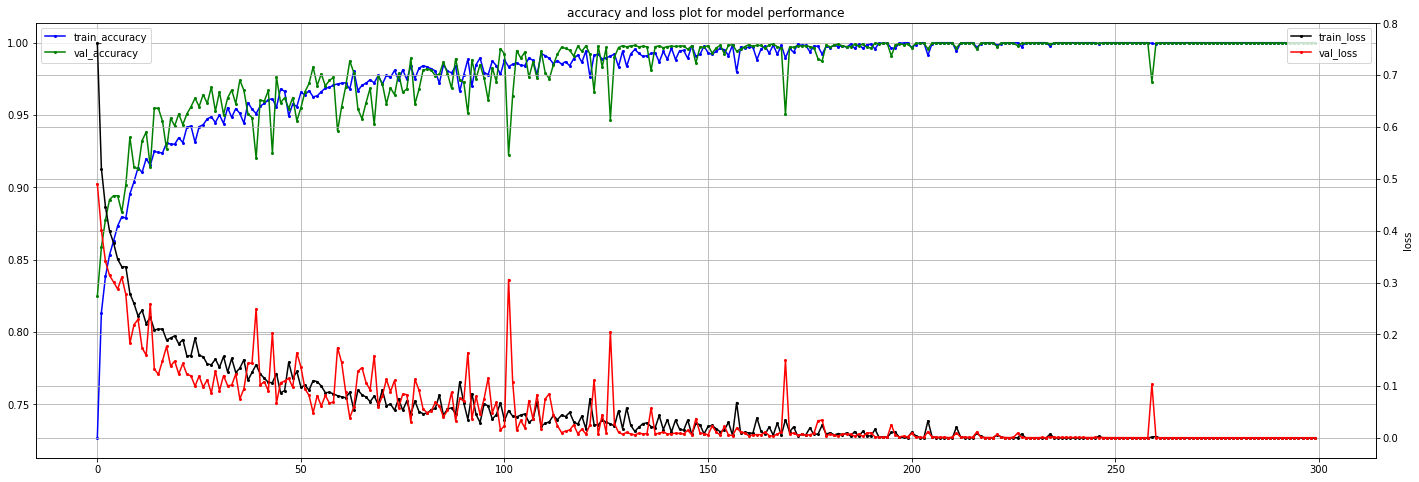

In [ ]:
plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None)

In [ ]:
y_pred = predict(model, x_test)

422/422 [==============================] - 2s 3ms/step


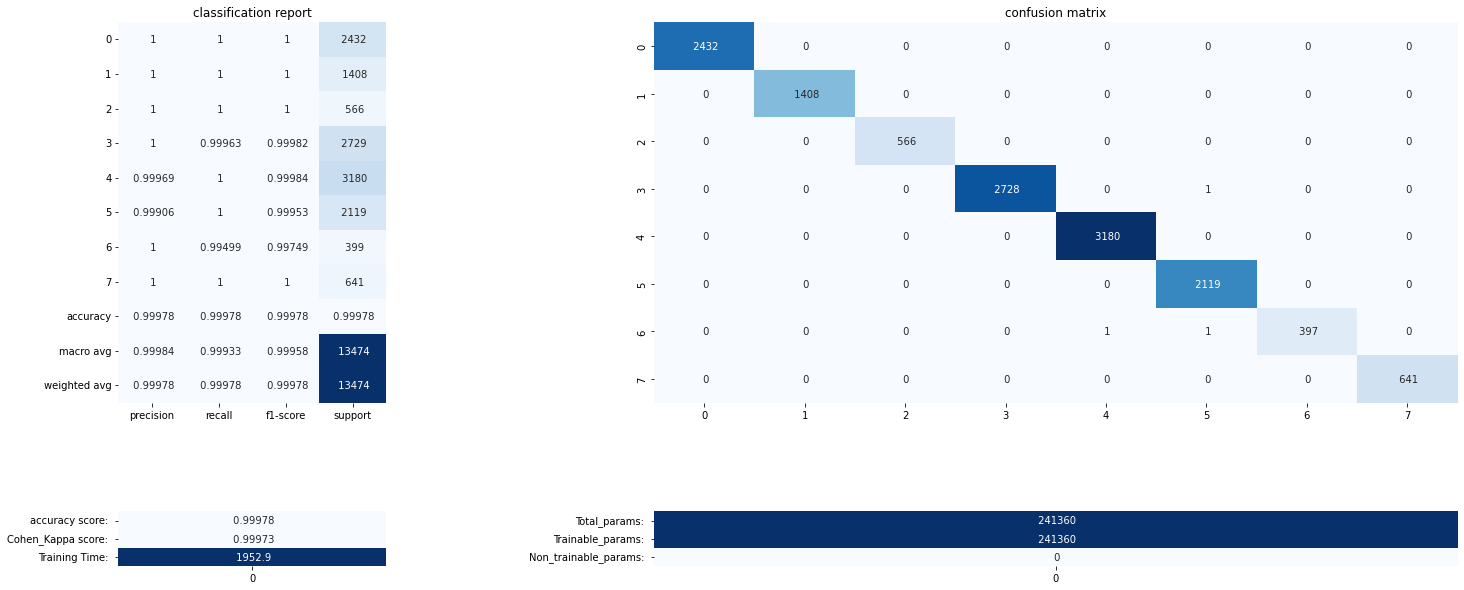

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = folder_path)

In [ ]:
for i in range(10):
    gc.collect()

In [ ]:
if use_pearson_corr:
    filepath1 = folder_path +"Results/ "+ str(train_percent)+"% performance.txt"
else:
    filepath1 = folder_path +"Results/"+ str(train_percent)+"% performance3_ps_"+str(P_S)+".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[2432    0    0    0    0    0    0    0]
 [   0 1408    0    0    0    0    0    0]
 [   0    0  566    0    0    0    0    0]
 [   0    0    0 2728    0    1    0    0]
 [   0    0    0    0 3180    0    0    0]
 [   0    0    0    0    0 2119    0    0]
 [   0    0    0    0    1    1  397    0]
 [   0    0    0    0    0    0    0  641]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      1408
           2       1.00      1.00      1.00       566
           3       1.00      1.00      1.00      2729
           4       1.00      1.00      1.00      3180
           5       1.00      1.00      1.00      2119
           6       1.00      0.99      1.00       399
           7       1.00      1.00      1.00       641

    accuracy                           1.00     13474
   macro avg       1.00      1.00      1.00     13474
weighted avg       1.00   

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)
if use_pearson_corr:
    img_path = folder_path +"Results/with_corr_"+str(train_percent)+"%_mlp_mixer_ps"+str(P_S)+".csv"
else:
    img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_mlp_mixer_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(img_path, y_combined, delimiter=",")

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

In [ ]:
y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([ 11522,   7968,   9918,  44927, 103066,  44279,   9310,  31154]))


In [ ]:
y_hat = y_hat.reshape((H,W))

In [ ]:
img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted3_image" + ".png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)
spectral.save_rgb("available_image.png", y, colors = spectral.spy_colors)

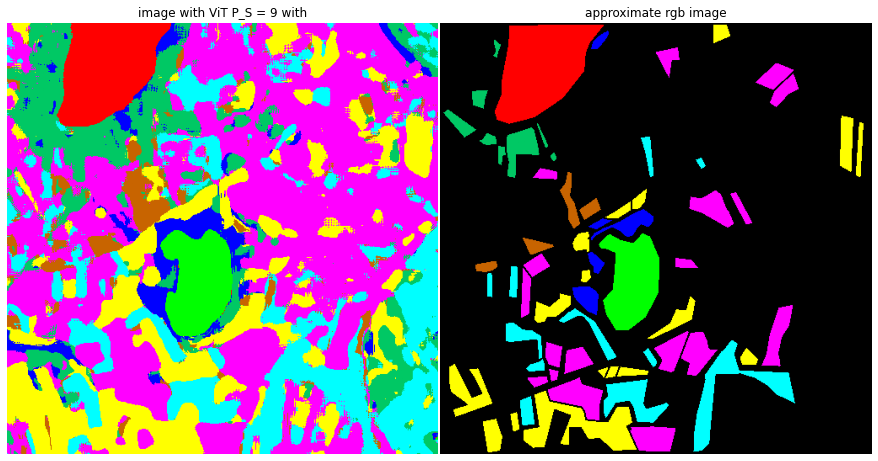

In [ ]:
# img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image with" + str(method) + ".png"
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (12, 12))
img = plt.imread(img_path)
ax1.imshow(plt.imread(img_path))
ax1.set_title("image with ViT P_S = 9 with")
ax1.axis("off")

ax2.imshow(plt.imread("/content/available_image.png"))

ax2.set_title("approximate rgb image")
ax2.axis("off")

plt.tight_layout(pad = 0, h_pad=0, w_pad=0.2)
plt.show()